In [1]:
#!pip install nibabel tqdm scikit-image

In [1]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [15]:
#GPU 확인
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13622805400401576749
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914163099
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15542060171685109914
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


True

In [5]:
#데이터 셋 가져오기
def get_mask_data():

    x_train_path = "dataset/Image_Segmentation/x_train2.npy"
    x_val_path = "dataset/Image_Segmentation/x_val2.npy" 
    y_train_path = "dataset/Image_Segmentation/y_train2.npy"
    y_val_path = "dataset/Image_Segmentation/y_val2.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [6]:
# CNN 인 VGG16 U-net
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [8]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    
    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')
    

    preds = model.predict(x_val)
    fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
    temp = np.empty((256, 256, 1), dtype=np.float32)

    for i in range(40):
        ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
        ax[i, 0].title.set_text(str(i))
    
        y_val_0 = y_val[...,0]
        ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
        predict_0 = preds[...,0]
        ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
        temp = x_val[i]
        pred_sum = predict_0[i][predict_0[i] > 0]
        pred_mean = np.mean(predict_0)
        if(np.min(temp) >= 0) :
            temp[predict_0[i] < 0.5] = 0
        else :
            temp[predict_0[i] < 0.5] = -2048
        ax[i, 3].imshow(temp.squeeze(), cmap='gray')


In [9]:
x_train, y_train, x_val, y_val = get_mask_data()
print(y_train.max(), y_train.min())
print(x_train.max(), x_train.min())
print(x_val.max(), x_val.min())
# model = VGG16_Unet(x_train, y_train2, x_val, y_val2)
# history = training(model,x_train, y_train2, x_val, y_val2)

(2675, 256, 256, 1) (2675, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
1 0
1.0 0.0
1.0 0.0


In [10]:
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][0]                   
______________________________________________________________________________________________

Epoch 1/30


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-8-cb9d006936f6>:2) ]]
	 [[confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/pivot_f/_12/_41]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-8-cb9d006936f6>:2) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6770]

Function call stack:
train_function -> train_function


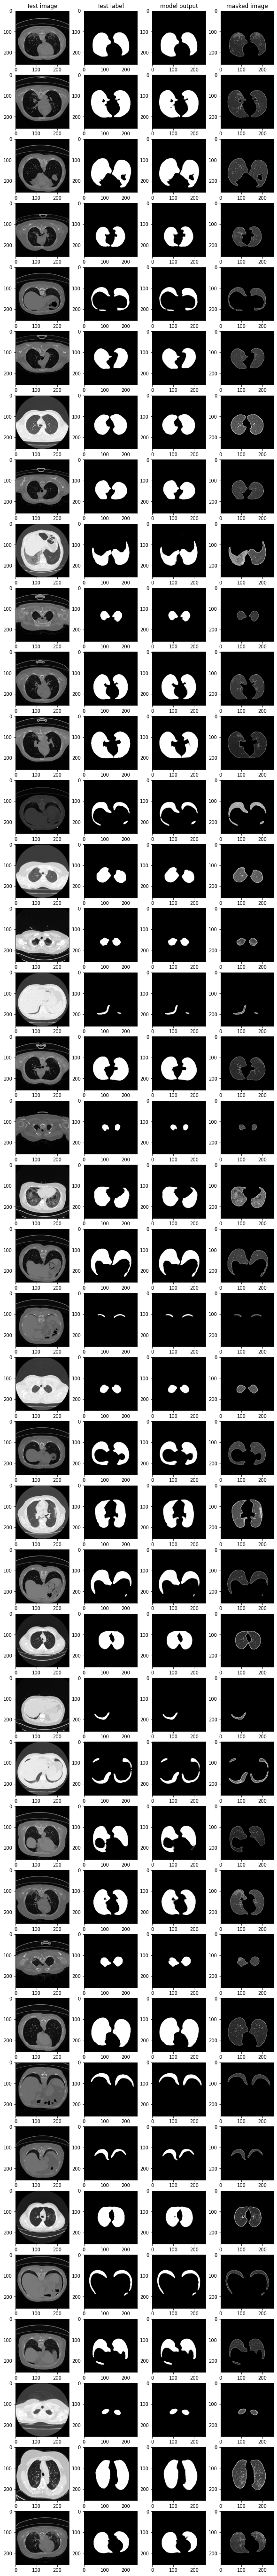

In [10]:
preds = model.predict(x_val)
fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

ax[0, 0].title.set_text("Test image")
ax[0, 1].title.set_text("Test label")
ax[0, 2].title.set_text("model output")
ax[0, 3].title.set_text("masked image")
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    
    y_val_0 = y_val[...,0]
    ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
    predict_0 = preds[...,0]
    ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
    temp = x_val[i]
    pred_sum = predict_0[i][predict_0[i] > 0]
    pred_mean = np.mean(predict_0)
    temp[predict_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='gray')
    

In [12]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = preds[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output index번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if y_label_image[i][j] == 1 or predict_image[i][j] == 1:
                if y_label_image[i][j] == 1 and predict_image[i][j] == 1:
                    TP = TP + 1
                else :
                    NP = NP + 1
            
    if TP == 0 and NP == 0 : 
        TP = 1
    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image + 1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 12193 NP :  208
IOU : 0.9832271591000725 

Number :  1 TP : 15182 NP :  260
IOU : 0.9831628027457583 

Number :  2 TP : 15283 NP :  351
IOU : 0.9775489318152744 

Number :  3 TP : 8376 NP :  208
IOU : 0.9757688723205965 

Number :  4 TP : 5465 NP :  199
IOU : 0.9648658192090396 

Number :  5 TP : 9951 NP :  123
IOU : 0.9877903513996427 

Number :  6 TP : 10586 NP :  104
IOU : 0.9902712815715622 

Number :  7 TP : 9320 NP :  93
IOU : 0.9901200467438649 

Number :  8 TP : 9018 NP :  278
IOU : 0.9700946643717728 

Number :  9 TP : 2972 NP :  71
IOU : 0.9766677620768978 

Number :  10 TP : 12059 NP :  146
IOU : 0.988037689471528 

Number :  11 TP : 14460 NP :  350
IOU : 0.9763673193787981 

Number :  12 TP : 4466 NP :  263
IOU : 0.9443857052230915 

Number :  13 TP : 6148 NP :  181
IOU : 0.9714014852267341 

Number :  14 TP : 2176 NP :  138
IOU : 0.9403630077787382 

Number :  15 TP : 735 NP :  43
IOU : 0.9447300771208226 

Number :  16 TP : 12775 NP :  190
IOU : 0.9853451

Number :  137 TP : 8672 NP :  78
IOU : 0.9910857142857142 

Number :  138 TP : 229 NP :  23
IOU : 0.9087301587301587 

Number :  139 TP : 1891 NP :  61
IOU : 0.96875 

Number :  140 TP : 10711 NP :  247
IOU : 0.977459390399708 

Number :  141 TP : 8905 NP :  314
IOU : 0.9659399067143942 

Number :  142 TP : 889 NP :  81
IOU : 0.9164948453608247 

Number :  143 TP : 15077 NP :  436
IOU : 0.9718945400631728 

Number :  144 TP : 7019 NP :  322
IOU : 0.9561367661081597 

Number :  145 TP : 9253 NP :  121
IOU : 0.9870919564753574 

Number :  146 TP : 14956 NP :  357
IOU : 0.9766864755436557 

Number :  147 TP : 9195 NP :  331
IOU : 0.9652529918118833 

Number :  148 TP : 11660 NP :  84
IOU : 0.9928474114441417 

Number :  149 TP : 132 NP :  24
IOU : 0.8461538461538461 

Number :  150 TP : 14700 NP :  308
IOU : 0.9794776119402985 

Number :  151 TP : 7608 NP :  130
IOU : 0.9831997932282244 

Number :  152 TP : 4173 NP :  133
IOU : 0.9691128657686948 

Number :  153 TP : 4426 NP :  99
IOU : 0

Number :  272 TP : 7194 NP :  170
IOU : 0.9769147202607279 

Number :  273 TP : 15418 NP :  206
IOU : 0.9868151561699949 

Number :  274 TP : 3654 NP :  134
IOU : 0.9646251319957762 

Number :  275 TP : 9579 NP :  181
IOU : 0.9814549180327868 

Number :  276 TP : 6313 NP :  106
IOU : 0.9834865243807447 

Number :  277 TP : 7952 NP :  84
IOU : 0.9895470383275261 

Number :  278 TP : 6129 NP :  278
IOU : 0.9566099578585922 

Number :  279 TP : 2797 NP :  134
IOU : 0.9542818150801774 

Number :  280 TP : 1784 NP :  92
IOU : 0.9509594882729211 

Number :  281 TP : 11324 NP :  357
IOU : 0.9694375481551237 

Number :  282 TP : 7964 NP :  227
IOU : 0.972286656085948 

Number :  283 TP : 14213 NP :  374
IOU : 0.9743607321587715 

Number :  284 TP : 11870 NP :  323
IOU : 0.9735093906339704 

Number :  285 TP : 12170 NP :  420
IOU : 0.9666401906274821 

Number :  286 TP : 16239 NP :  192
IOU : 0.9883147708599598 

Number :  287 TP : 14185 NP :  251
IOU : 0.9826129121640343 

Number :  288 TP : 5